# PHYS6318: Lecture 4

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rcParams
rcParams['animation.html'] = 'jshtml'
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4
import time
import os
import glob

## OMB 4.5 The Multi-Layer Shallow-Water Model

Consider multiple layers of different densities under the shallow-water assumption.  Number layers from top to bottom and the surface layer carries the index 1.

Momentum equation for layer $i$:

$$
\frac{\partial u_i}{\partial t} = - \frac{1}{\rho_i}\frac{\partial P_i}{\partial x} $$

Dynamic pressure in the layers are given by:

$$
\begin{align}
P_1 &= \rho_1 g \eta_1 \\
P_2 &= P_1 + (\rho_2 - \rho_1) g \eta_2 \\
P_3 &= P_2 + (\rho_3 - \rho_2) g \eta_3 \\
\vdots   \\
P_{nz-1} &= P_{nz-2} + (\rho_{nz-1} - \rho_{nz-2}) g \eta_{nz-1} \\
P_{nz} &= P_{nz-1} + (\rho_{nz} - \rho_{nz-1}) g \eta_{nz}
\end{align}
$$

See OMB Fig 4.16 for configuration.

Compare with *dynamic pressure* from OMB 3.11.4

$$P(z^*) = \rho_0 g \eta + g \int_{z^*}^\eta \rho' dz$$

where $\rho'$ is the density anomaly compared to the mean density $\rho_0$ and $z^*$ is the vertical location in the water column.


In a generalized form, we have

$$P_i = P_{i-1} - (\rho_i - \rho_{i-1}) g \eta_i \;\;\mbox{for}\; \;i=1,2,3,\ldots, nz$$


where $\eta_i$ are the interface displacement with respect to equilibrium levels.   The boundaries are $P_0 = 0$ and $\rho_0 = 0$ which ignores atmospheric pressure and assumes air density is zero.

Conservation of volume in each layer corresponds to the equations for layer-thickness:

$$ \frac{\partial h_i}{\partial t} = - \frac{\partial (u_i h_i) }{\partial x } $$

Layer thicknesses are given by:

$$h_i = h_{i,o} - \eta_{i+1} + \eta_i $$

where $h_{i,o}$ are the undisturbed thickness for a fluid at rest and $\eta_{nz+1} = 0$ represents a rigid seafloor.

Using this relation, we can write the layer thickness equations as equations for interface displacement:

$$
\begin{align}
\frac{\partial \eta_{nz}}{\partial t}  &= - \frac{\partial (u_{nz} h_{nz}) }{\partial x } \\
- \frac{\partial\eta_{nz}}{\partial t} +  \frac{\partial \eta_{nz-1}}{\partial t} &= - \frac{\partial (u_{nz-1} h_{nz-1}) }{\partial x } \\
\vdots \\
-  \frac{\partial\eta_{3}}{\partial t} + \frac{\partial \eta_{2}}{\partial t} &= - \frac{\partial (u_{2} h_{2}) }{\partial x }  \\
-  \frac{\partial\eta_{2}}{\partial t} + \frac{\partial \eta_{1}}{\partial t} &= - \frac{\partial (u_{1} h_{1}) }{\partial x }  
\end{align}
$$

which in generalized form are

$$ \frac{\partial \eta_{i}}{\partial t} = - \frac{\partial (u_{i} h_{i}) }{\partial x }  +  \frac{\partial\eta_{i+1}}{\partial t}  \;\;\mbox{for}\; \;i=nz, nz-1, \ldots, 1$$

with $\eta_{nz+1} = 0$ representing the rigid seafloor.   Note that, in constrast to the pressure iteration, this iteration goes bottom to top.

## OMB 4.6 Exercise 7: Long Waves in a Layered Fluid

### Description

Stratified fluid consisting of 10 layers of initial thickness of 10 m each.

In [2]:
nz = 10
dz = 10

# mid-points of each layer
z_rho = np.arange(dz/2, -dz*nz, -dz)

z_eta = np.arange(dz, -dz*(nz+1), -dz)

Top layer of fluid is $\rho_1$ = 1025 kg/m$^3$ (atmosphere layer is $\rho_0 = 0$)

Second layer to the bottom is linear profile from 1026 kg/m$^3$ to 1026.5 kg/m$^3$

In [3]:
rho = np.empty(nz+1) # layer densities
    
rho[0] = 0 # air density ignored
rho[1] = 1025
for i in range(2, nz+1):
    rho[i] = 1026 + (i-2)/(nz-2)*0.5

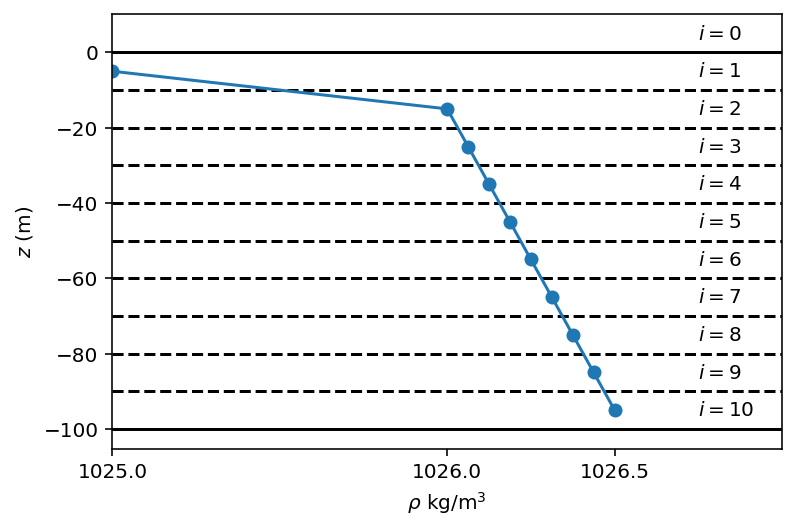

In [4]:
for i in range(nz+1):
    plt.axhline(-i*dz, color='k', linestyle='--')
    plt.text(1026.75, z_rho[i], f'$i = {i}$', verticalalignment='center')
plt.axhline(0, color='k', linestyle='-')
plt.axhline(-100, color='k', linestyle='-')

plt.plot(rho, z_rho, 'o-')
plt.xlim(1025, 1027)
plt.xlabel('$\\rho $ kg/m$^3$')
plt.ylabel('$z$ (m)')
plt.xticks ([1025, 1026, 1026.50])

plt.show()

Horizontal, we consider a domain of 1010 m discretized into 101 cells in the $x$-direction plus cell for each lateral boundary.

In [5]:
# grid parameters
nx = 101
dx = 10
xmax = 1010

x_eta = np.empty(nx+2)

x_eta[:] = np.arange(-0.75*dx, xmax+dx, dx)

There is triangle shaped bathymetry in the middle of the domain:

In [6]:
htotal = np.empty(nx+2)
                  
# bathymetry
for k in range(1, nx+1):
    htotal[k] = 100

# triangle-shaped island
for k in range(31, 52):
    htotal[k] = 100 - 95*(k-30)/21
for k in range(52, 72):
    htotal[k] = 100 - 95*(71 - k + 1)/20

htotal[0] = -10
htotal[nx+1] = -10
    

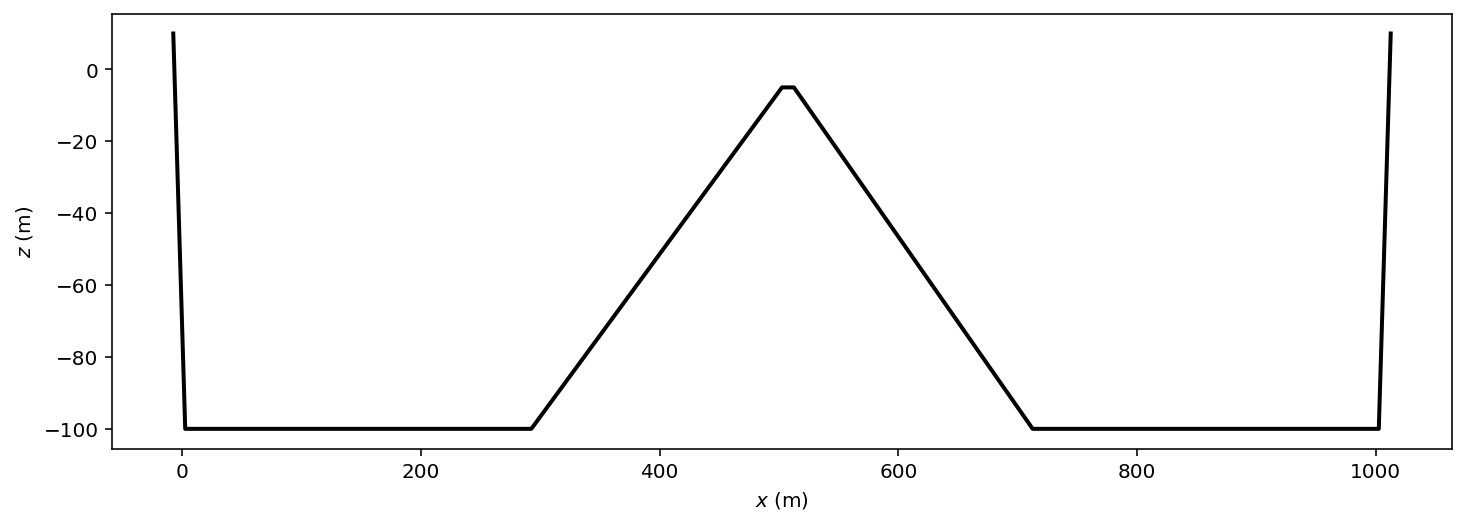

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(x_eta, -htotal, linewidth=2, color='k')
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.show()

In the model we need to track the 
- displacement of each interface, `eta` (and hence the thickness of each layer, `h`)
- dynamic pressure, `dp`
- the horizontal velocity, `u`

In [15]:
eta = np.empty((nz+2, nx+2)) # actual interface displacements
etan = np.empty((nz+2, nx+2)) # interface displacements at time level n+1
h = np.empty((nz+2, nx+2)) # actual layer thicnesses

dp = np.empty((nz+1, nx+2)) # dynamic pressure

u = np.empty((nz+1, nx+2)) # actual lateral velocity
un = np.empty((nz+1, nx+2)) # lateral velocity at time level n+1

wet = np.empty((nz+2, nx+2), dtype=int) # wet and dry pointer
dhdt = np.empty((nz+2, nx+2)) # actual layer-thickness change

We initialize the layer thickness and interface displacement with respect to the bathymetry:

In [16]:
# undisturbed layer thicknesses & interface displacements
hini = np.ones(nz+1)*10

for k in range(0, nx+2):
    htot = htotal[k]
    for i in range(1, nz+1):
        h[i, k] = max( min( hini[i], htot), 0)
        eta[i, k] = max(0, -htot)
        htot = htot - hini[1]
eta[nz+1, :] = 0 # sea floor is rigid

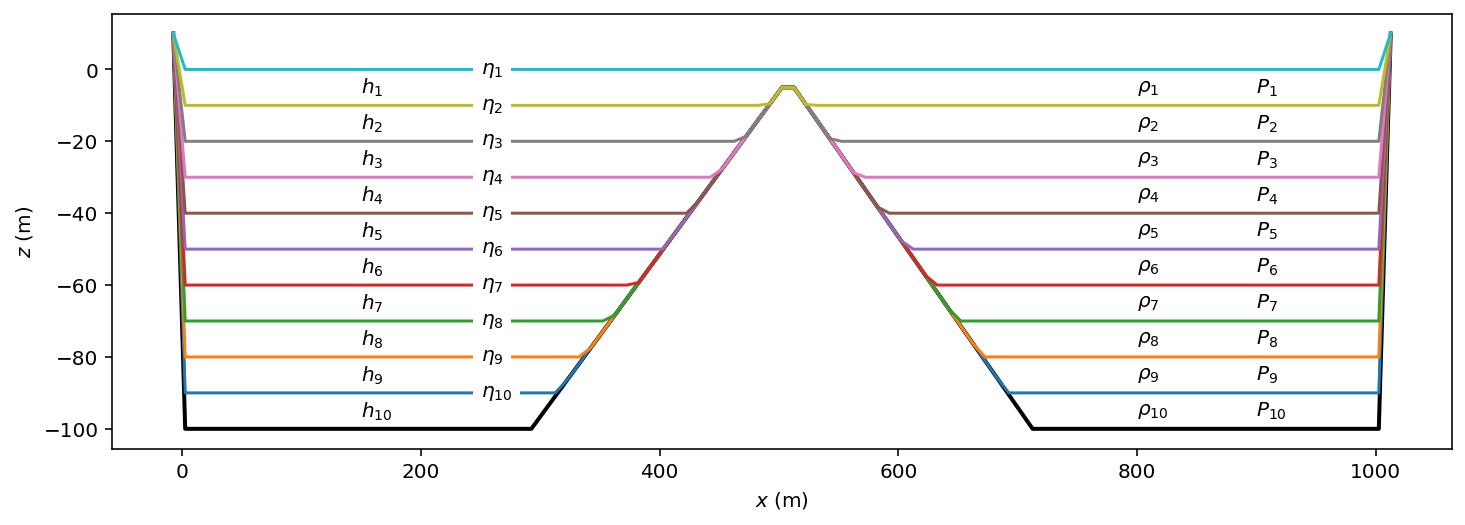

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(x_eta, -htotal, linewidth=2, color='k')
for i in range(nz, 0, -1):
    plt.plot(x_eta, z_eta[i]+eta[i,:])
    plt.text(150, z_rho[i], f'$h_{{{i}}}$', verticalalignment='center')
    plt.text(250, z_eta[i], f'$\eta_{{{i}}}$', bbox=dict(facecolor='white', edgecolor='none'), verticalalignment='center')
    plt.text(800, z_rho[i], f'$\\rho_{{{i}}}$', verticalalignment='center')
    plt.text(900, z_rho[i], f'$P_{{{i}}}$', verticalalignment='center')
    
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.show()

Dynamic pressure is calculate according to

$$P_i = P_{i-1} - (\rho_i - \rho_{i-1}) g \eta_i \;\;\mbox{for}\; \;i=1,2,3,\ldots, nz$$

during every dynamic update step as follows:

In [18]:
g = 9.81
# calculate dynamic pressure
for k in range(0, nx+2):
    dp[0, k] = 0 # air pressure ignored
    for i in range(1, nz+1):
        dp[i, k] = dp[i-1, k] + (rho[i] - rho[i-1])*g*eta[i, k]

The velocity is updated according to the momentum equations using the flooding algorithm (see OMB Exercise 6)

In [19]:
dt = 0.1

for k in range(1, nx+1):
    for i in range(1, nz+1):

        # velocity predictor for wet grid cells
        pgradx = -(dp[i, k+1]- dp[i, k])/rho[i]/dx
        un[i, k] = 0

        if wet[i, k]:
            if wet[i, k+1] or (pgradx>0):
                un[i, k] = u[i, k] + dt*pgradx
        else:
            if wet[i, k+1] and (pgradx<0):
                un[i, k] = u[i, k] + dt*pgradx

The layer thickesses and interface displacements are updated based on

$$ \frac{\partial \eta_{i}}{\partial t} = - \frac{\partial (u_{i} h_{i}) }{\partial x }  +  \frac{\partial\eta_{i+1}}{\partial t}  \;\;\mbox{for}\; \;i=nz, nz-1, \ldots, 1$$

which is coded as

In [20]:
# layer-thickness change predictor
for k in range(1, nx+1):
    for i in range(1, nz+1):
        hep = 0.5*(un[i,k]+abs(un[i,k]))*h[i,k]
        hen = 0.5*(un[i,k]-abs(un[i,k]))*h[i,k+1]
        hue = hep+hen
        hwp = 0.5*(un[i,k-1]+abs(un[i, k-1]))*h[i,k-1]
        hwn = 0.5*(un[i,k-1]-abs(un[i, k-1]))*h[i,k]
        huw = hwp+hwn

        dhdt[i,k] = -(hue-huw)/dx

# update interface displacements
for k in range(1, nx+1):
    deta = 0
    for i in range(nz, 0, -1):
        deta = deta + dhdt[i, k]
        etan[i, k] = eta[i, k] + dt*deta

We again use a Shapiro filter to dampen the high frequencies numerical noise.

In [21]:
## global, fixed parameters

# grid parameters
xmax = 1010
dx = 10 # grid spacing
nx = 101
nz = 10

# physical parameters
g = 9.81 # acceleration due to gravity
hmin = 0.01 # minimum layer thickness

eps = 0.05

In [22]:
x_eta = np.empty(nx+2) # horizontal grid for depths and displacements
x_u = np.empty(nx+2) # horizontal grid for horizontal velocities
z = np.empty(nz+2) # vertical grid

htotal = np.empty(nx+2) # initial bathymetry
hzero = np.empty((nz+2, nx+2)) # initial layer thicknesses
h = np.empty((nz+2, nx+2)) # actual layer thicnesses
dp = np.empty((nz+2, nx+2)) # dynamic pressure

eta = np.empty((nz+2, nx+2)) # actual interface displacements
etan = np.empty((nz+2, nx+2)) # interface displacements at time level n+1
eta0 = np.empty((nz+2, nx+2)) # initial interface displacements
dhdt = np.empty((nz+2, nx+2)) # actual layer-thickness change
u = np.empty((nz+2, nx+2)) # actual lateral velocity
un = np.empty((nz+2, nx+2)) # lateral velocity at time level n+1
rho = np.empty(nz+2) # layer densities

wet = np.empty((nz+2, nx+2), dtype=int) # wet and dry pointer

In [23]:
def init_output(basename='', **attrs):
      
    # ensure we are writing to a new file each time
    previous_files = sorted(glob.glob(f'OUTPUT/{basename}_*.nc'))
    if len(previous_files) == 0:
        counter = 1    
    else:
        counter = int(previous_files[-1][-7:-3]) + 1
    filename = f'OUTPUT/{basename}_{counter:04d}.nc'
        
    nc = netCDF4.Dataset(filename, "w")

    # NetCDF files have 'dimensions'
    nc.createDimension("time")
    nc.createDimension("x", nx+2)
    nc.createDimension("z", nz+2)

    # NetCDF files have 'variables'
    nc.createVariable("time", "f8", ("time",))
    # NetCDF variables can have 'attributes'
    nc.variables["time"].units = "seconds since 2000-01-01"
    nc.variables["time"].calendar = "gregorian"
    
    nc.createVariable("x_eta", "f8", ("x"))
    nc.variables["x_eta"].units = "m"
    nc.variables["x_eta"][:] = x_eta
    
    nc.createVariable("x_u", "f8", ("x"))
    nc.variables["x_u"].units = "m"
    nc.variables["x_u"][:] = x_u
      
    nc.createVariable("htotal", "f8", ("x"))
    nc.variables["htotal"].units = "m"
    nc.variables["htotal"][:] = htotal
    
    nc.createVariable("eta", "f8", ("time", "z", "x"))
    nc.variables["eta"].units = "m"
    nc.createVariable("u", "f8", ("time", "z", "x"))
    nc.variables["u"].units = "m s-1"
    nc.createVariable("h", "f8", ("time", "z", "x"))
    nc.variables["h"].units = "m"

    # NetCDF files have also have global attributes
    nc.setncatts(attrs)
    nc.history = "Created " + time.ctime(time.time())
    nc.source = "OMB Exercise 7"

    # It is important to close a NetCDF file
    nc.close()
    
    return filename

def write_output(filename, t, n=None):
    # open a NetCDF file in 'append' mode
    nc = netCDF4.Dataset(filename, mode='a')
    
    # if n is not provided, place values in the last position
    if n is None:
        n = len(nc.variables['time'])
        
    nc.variables["time"][n] = t
    nc.variables["eta"][n, :, :] = eta
    nc.variables["h"][n, :, :] = h
    nc.variables["u"][n, :, :] = u
    
    # It is important to close a NetCDF file
    nc.close()

### Subroutines

In [24]:
def init():

    # calculate horizontal grids
    x_eta[:] = np.arange(-0.75 * dx, xmax+dx, dx)
    x_u[:] = x_eta + 0.5 * dx
    
    # bathymetry
    for k in range(1, nx+1):
        htotal[k] = 100
        
    # triangle-shaped island
    for k in range(31, 52):
        htotal[k] = 100 - 95*(k-30)/21
    for k in range(52, 72):
        htotal[k] = 100 - 95*(71 - k + 1)/20

    htotal[0] = -10
    htotal[nx+1] = -10
    
    # undisturbed layer thicknesses & interface displacements
    hini = np.ones(nz+2)*10
        
    for k in range(0, nx+2):
        htot = htotal[k]
        for i in range(1, nz+1):
            hzero[i, k] = max( min( hini[i], htot), 0)
            eta[i, k] = max(0, -htot)
            htot = htot - hini[1]
            
    # layer densities
    rho[0] = 0 # air density ignored
    rho[1] = 1025
    for i in range(2, nz+1):
        rho[i] = 1026 + (i-2)/(nz-2)*0.5
        
    # boundary values for dp and eta
    for k in range(0, nx+2):
        dp[0, k] = 0 # air pressure ignored
        eta[nz+1, k] = 0 # sea floor is rigid
            
    # store initial interface displacements
    for k in range(0, nx+2):
        for i in range(1, nz+2):
            eta0[i, k] = eta[i, k]
            
    # layer thicknesses, wet\dry pointers and velocities
    for i in range(1, nz+1):
        for k in range(0, nx+2):
            h[i, k] = hzero[i, k]
            wet[i, k] = 1
            if h[i, k] < hmin:
                wet[i, k] = 0
            u[i, k] = 0
            un[i, k] = 0

        
def dyn():
    
    # calculate dynamic pressure
    for k in range(0, nx+2):
        for i in range(1, nz+1):
            dp[i, k] = dp[i-1, k] + (rho[i] - rho[i-1])*g*eta[i,k]
            
    for k in range(1, nx+1):
        for i in range(1, nz+1):
            
            # velocity predictor for wet grid cells
            pgradx = -(dp[i, k+1]- dp[i, k])/rho[i]/dx
            un[i, k] = 0
            
            if wet[i, k]:
                if wet[i, k+1] or (pgradx>0):
                    un[i, k] = u[i, k] + dt*pgradx
            else:
                if wet[i, k+1] and (pgradx<0):
                    un[i, k] = u[i, k] + dt*pgradx

    # layer-thickness change predictor
    for k in range(1, nx+1):
        for i in range(1, nz+1):
            hep = 0.5*(un[i,k]+abs(un[i,k]))*h[i,k]
            hen = 0.5*(un[i,k]-abs(un[i,k]))*h[i,k+1]
            hue = hep+hen
            hwp = 0.5*(un[i,k-1]+abs(un[i, k-1]))*h[i,k-1]
            hwn = 0.5*(un[i,k-1]-abs(un[i, k-1]))*h[i,k]
            huw = hwp+hwn

            dhdt[i,k] = -(hue-huw)/dx

            
    # update interface displacements
    for k in range(1, nx+1):
        deta = 0
        for i in range(nz, 0, -1):
            deta = deta + dhdt[i, k]
            etan[i, k] = eta[i, k] + dt*deta
            
    # apply Shapiro filter
    shapiro()
    
    # update layer thicknesses, lateral velocities and wet/dry pointers
    for k in range(1, nx+1):
        for i in range(1, nz+1):
            h[i, k] = hzero[i, k] + eta[i, k] - eta[i+1, k] - eta0[i, k] + eta0[i+1, k]
            u[i, k] = un[i, k]
            wet[i, k] = 1
            if h[i, k] < hmin:
                wet[i, k] = 0
    
def shapiro():
    for i in range(1, nz+1):
        for k in range(1, nx+1):
            if wet[i, k]:
                term1 = (1.0-0.5*eps*(wet[i, k+1]+wet[i, k-1]))*etan[i, k]
                term2 = 0.5*eps*(wet[i, k+1]*etan[i, k+1]+wet[i, k-1]*etan[i, k-1])
                eta[i, k] = term1 + term2
            else:
                eta[i, k] = etan[i, k]

In [29]:
def multi():
    
    # initialize arrays to the initial values
    init()
    
    # determine maximum water depth
    # automatic setting of time step (10% below CFL threshold)
    hmax = 100 # total water depth
    dt = 0.9 * dx / np.sqrt(g*hmax)
    print(f"Time step = {dt:.1f} seconds")
    
    # set epsilon for Shapiro filter
    eps = 0.05
        
    # parameters for wave paddle
    Apaddle = 1 # amplitude in metres
    Tpaddle = 10 # period in seconds CASE 1
    #Tpaddle = 2*3600 # period in seconds CASE 2
    
    
    # runtime parameters
    tmax = 10 * Tpaddle
    ntot = int(tmax/dt)

    # output parameter
    tout = Tpaddle/10
    nout = int(tout / dt)
    
    filename = init_output('multi')
    
    for n in range(ntot):
        t = n*dt
        
        for i in range(1, nz+1):
            eta[i, 1] = Apaddle*np.sin(2*np.pi*t/Tpaddle)

        #---- prognostic equations ----
        dyn()
        #------------------------------

        if n % nout == 0:
            write_output(filename, t)
            
    return filename

In [32]:
def animate(filename):
    
    ds = xr.open_dataset(filename)
      
    # the time grid is stored in the netcdf output file
    t = (ds.time - ds.time[0]).dt.seconds.values
    
    fig, ax = plt.subplots(figsize=(12, 4), dpi=72)
    
    lines = []
    for i in range(1, nz+1):
        line, = ax.plot([], [], '-', lw=2)
        lines.append(line)
        
    time_text = ax.text(650, 5, '')
    
    plt.plot(x_eta, -htotal, linewidth=2, color='k')

    
    def init():
        
        ax.plot(ds.x_eta, -ds.htotal, 'k-', lw=1)
    
        ax.set_xlim(0, xmax)
        ax.set_ylim(-100, 20)
        ax.set_ylabel('z (m)')
        ax.set_xlabel('x (m)')
        ax.set_title(f"")

        return *lines, time_text

    dz = 10
    def update(frame):
        
        for i in range(1, nz+1):
            eta = ds.eta.isel(z=i, time=frame)
            lines[i-1].set_data(ds.x_eta, z_eta[i]+eta)
                
        time_text.set_text(f'Time = {t[frame]} seconds')
        
        return *lines, time_text

    anim = FuncAnimation(fig, update, 
                         frames=len(t),
                         init_func=init, blit=True)

    plt.close()
    
    return anim

In [31]:
filename = multi()

Time step = 0.3 seconds


In [33]:
animate(filename)

We see wave propagating left to right across the domain.  This is barotropic wave since all of the interfaces are oscillating in unison with the sea surface.

The phase speed of the wave is 

$$ c \approx \sqrt{g H} $$

where $H$ is the total depth of the water column.  

In [34]:
H = 100
g = 9.81
c = np.sqrt(g*H)

Here $H$ = 100 m, so we should expect that the phase speed is

In [35]:
print(f'{c:.1f} m/s')

31.3 m/s


For the wave to travel $L=500$ m (to from the boundary to the mid point of the domain),

In [36]:
L = 500
t = L / c

we can predict the time to be

In [37]:
print(f'{t:.1f} s')

16.0 s


However, from the animation about we can see that the wave has travelled only about 160 m.  Clearly, something is wrong with our simulation. (Also, I'm not getting the same result as the textbook got!)

Checks like this are important for verifying a numerical model is working as expected. 

## FORTRAN

- OMB 2.2.12
- OMB 2.2.13
- OMB 4.2.13


In [79]:
path = 'Codes_OMB/Updated_Exercises_March_2015/Exercise 7'

In [80]:
ls "{path}"

Info.txt      h.dat       main.f95   param.mod  sub.f95  u.dat
Makefile      h0.dat      main.o     param.o    sub.mod
TenLayer.sce  header.txt  param.f95  run.exe*   sub.o


In [81]:
import os

os.path.join(path, 'h.dat')

'Codes_OMB/Updated_Exercises_March_2015/Exercise 7/h.dat'

In [82]:
h_dat = np.loadtxt(os.path.join(path, 'h.dat'))

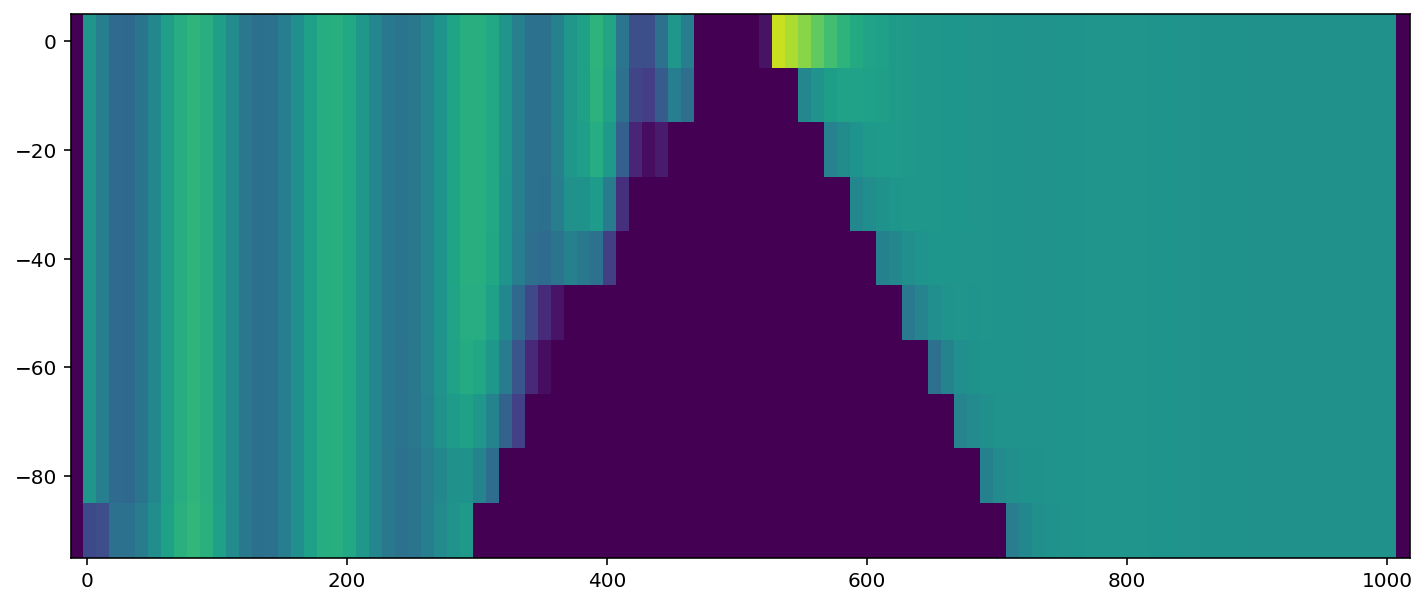

In [83]:
plt.figure(figsize=(12,5))
Z, X = np.meshgrid(x_eta, z_eta[1:nz+1])
plt.pcolor(Z, X, h[1:nz+1,:], shading='auto', vmin=9.7, vmax=10.3)
plt.show()

In [84]:
h.shape

(12, 103)

In [85]:
h_dat.shape

(1170, 101)

In [86]:
h_dat = h_dat.reshape(117, 10, 101)

In [87]:
h_dat.shape

(117, 10, 101)

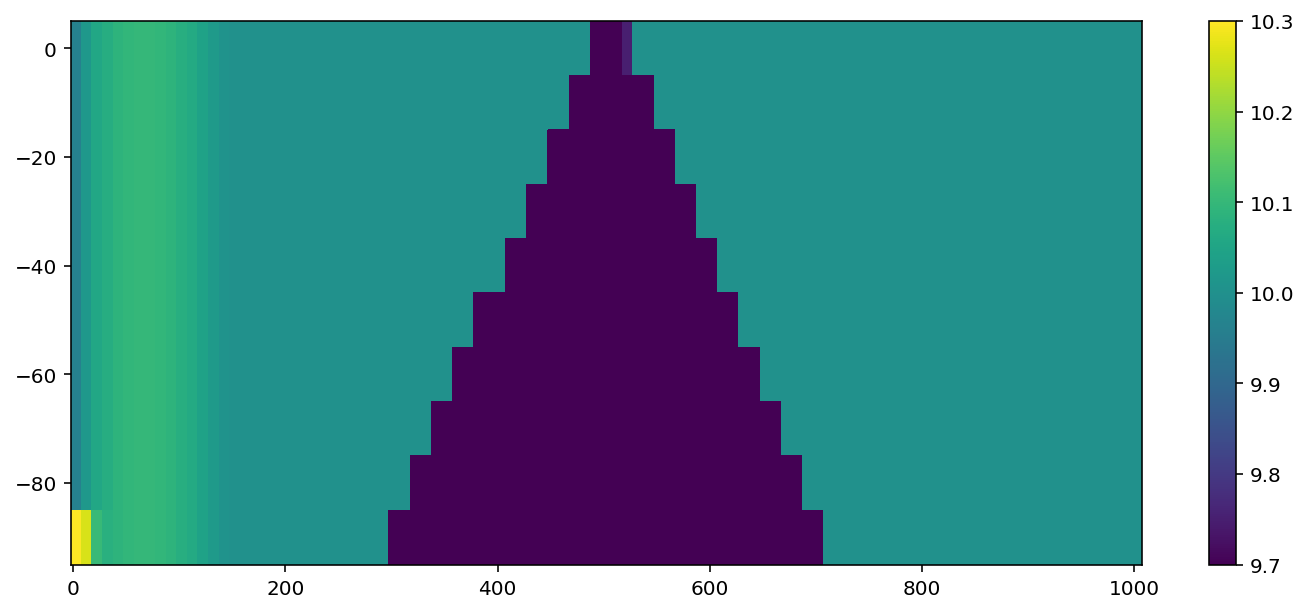

In [88]:
plt.figure(figsize=(12,5))
Z, X = np.meshgrid(x_eta[1:nx+1], z_eta[1:nz+1])
plt.pcolor(Z, X, h_dat[5, :, :], shading='nearest', vmin=9.7, vmax=10.3)
plt.colorbar()
plt.show()

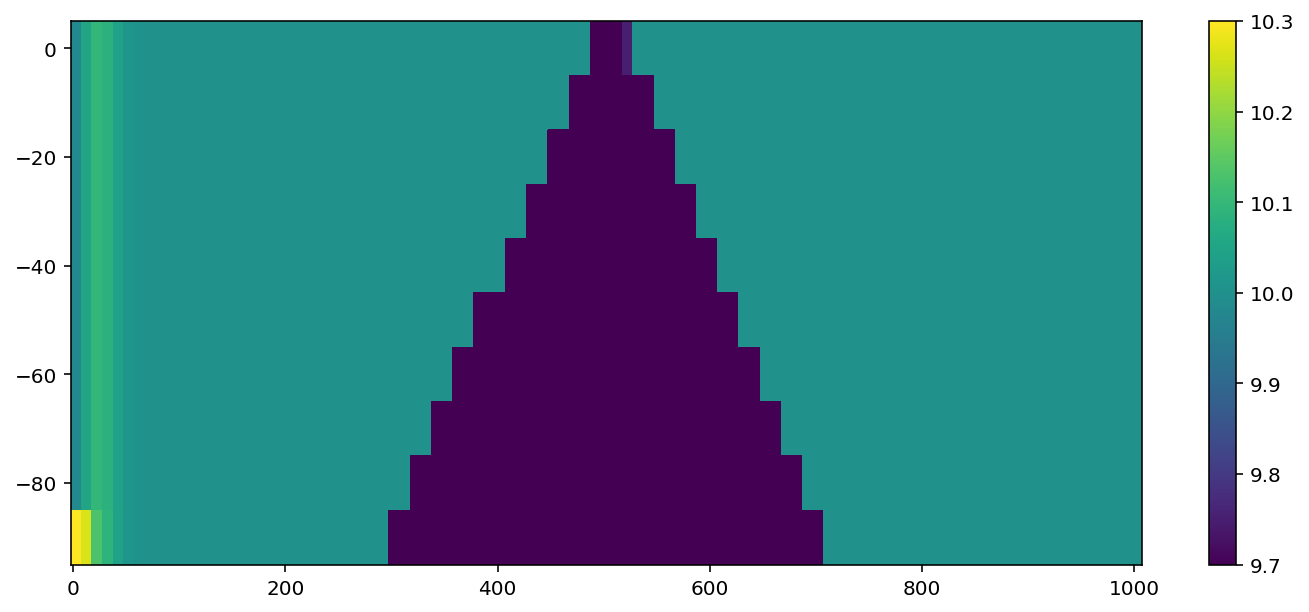

In [89]:
ds = xr.open_dataset(filename)

plt.figure(figsize=(12,5))
Z, X = np.meshgrid(x_eta[1:nx+1], z_eta[1:nz+1])
plt.pcolor(Z, X, ds.h.isel(time=5)[1:nz+1, 1:nx+1], shading='nearest', vmin=9.7, vmax=10.3)
plt.colorbar()
plt.show()

Discuss:
- WSL
- Fortran compilation and Makefiles
- text editor
- VS Code
- Debuggers

(After debugging, determined that `dt` needs to be a global variable!)

--- 
## Problem 7

Compile OMB Exercise 7 yourself with the provided Fortran code. Run the simulation for the "Internal Waves" case (`Tpadle = 2*3600`).  

Submit a `.ipynb` notebook showing a visualization of the results (your choice on how you would like to do this). There is no need to submit the Fortran code or your data. 

With reference to OMB 4.6.5, consider a two-layer fluid with the top layer only 10 m thick with a density of 1025 kg/m$^3$ and the bottom layer 90 m thick with a density of 1026.25 kg/m$^3$.  How does the phase speed of long interfacial waves compare to the phase speed in your simluation?

---